In [1]:
import networkx as nx
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score
import scipy.io
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.loader import NeighborLoader

In [21]:
def load_and_build_graph(file_path,nr=None):
    G = nx.Graph()

    with open(file_path, 'r') as f:
        for idx, line in enumerate(f):
            if nr and idx>nr:
                break
            node1, node2 = map(int, line.strip().split())
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += 1
            else:
                G.add_edge(node1, node2, weight=1)

    return G
file_path="ca-AstroPh.txt"
G=load_and_build_graph(file_path,1500)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1103 nodes and 1458 edges.


In [22]:
def compute_egonet_features(G):
    features = {}

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        egonet = G.subgraph(neighbors)

        N_i = len(neighbors)

        E_i = egonet.number_of_edges()

        W_i = sum(data['weight'] for u, v, data in egonet.edges(data=True))

        if len(egonet) > 0:
            adjacency_matrix = nx.to_numpy_array(egonet, weight='weight')
            eigenvalues = np.linalg.eigvals(adjacency_matrix)
            lambda_w_i = max(eigenvalues)
        else:
            lambda_w_i = 0

        features[node] = {
            'N_i': N_i,
            'E_i': E_i,
            'W_i': W_i,
            'lambda_w_i': lambda_w_i.real 
        }
    nx.set_node_attributes(G, features)
compute_egonet_features(G)

sample_node = next(iter(G.nodes))
print(f"Features for node {sample_node}: {G.nodes[sample_node]}")

Features for node 84424: {'N_i': 75, 'E_i': 9, 'W_i': 10, 'lambda_w_i': 3.5567305914849325}


In [33]:
nodes = list(G.nodes)
features = []
for node in nodes:
    neighbors = list(G.neighbors(node))
    N_i = len(neighbors)
    E_i = len(G.subgraph(neighbors).edges())
    if N_i > 0 and E_i > 0:
        features.append((node, N_i, E_i))

nodes, N_values, E_values = zip(*features)
log_N = np.log(N_values)
log_E = np.log(E_values)

model = LinearRegression()
log_N = log_N.reshape(-1, 1) 
model.fit(log_N, log_E)

theta = model.coef_[0]
log_C = model.intercept_
C = np.exp(log_C)

anomaly_scores = {}
for node, N_i, E_i in features:
    predicted_E = C * (N_i ** theta) 
    score = max(E_i, predicted_E) - min(E_i, predicted_E) * np.log(abs(E_i - predicted_E) + 1)
    anomaly_scores[node] = score


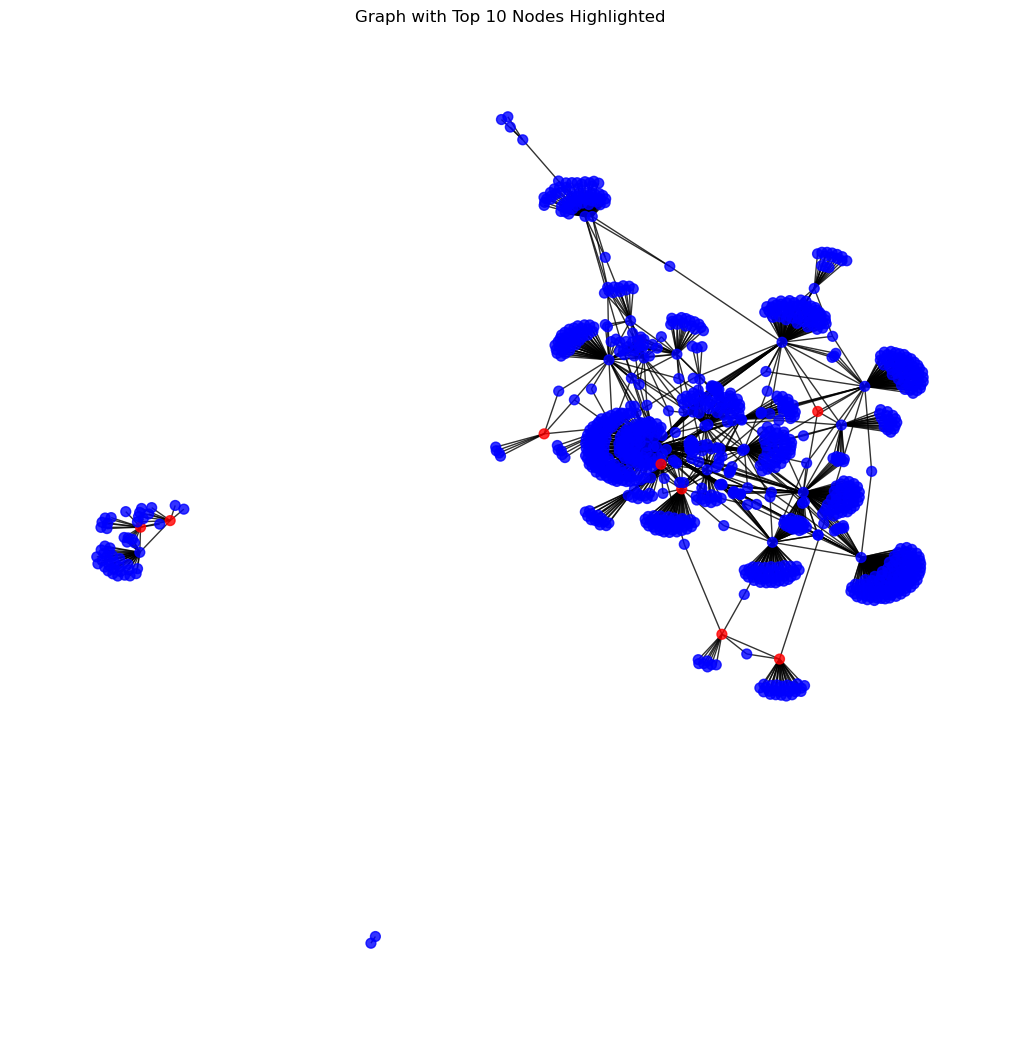

In [34]:
sorted_nodes = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)

top_10_nodes = [node for node, _ in sorted_nodes[:10]]

color_map = []
for node in G.nodes:
    if node in top_10_nodes:
        color_map.append("red")
    else:
        color_map.append("blue")

plt.figure(figsize=(10, 10))
nx.draw(G, node_color=color_map, with_labels=False, node_size=50, alpha=0.8)
plt.title("Graph with Top 10 Nodes Highlighted")
plt.show()

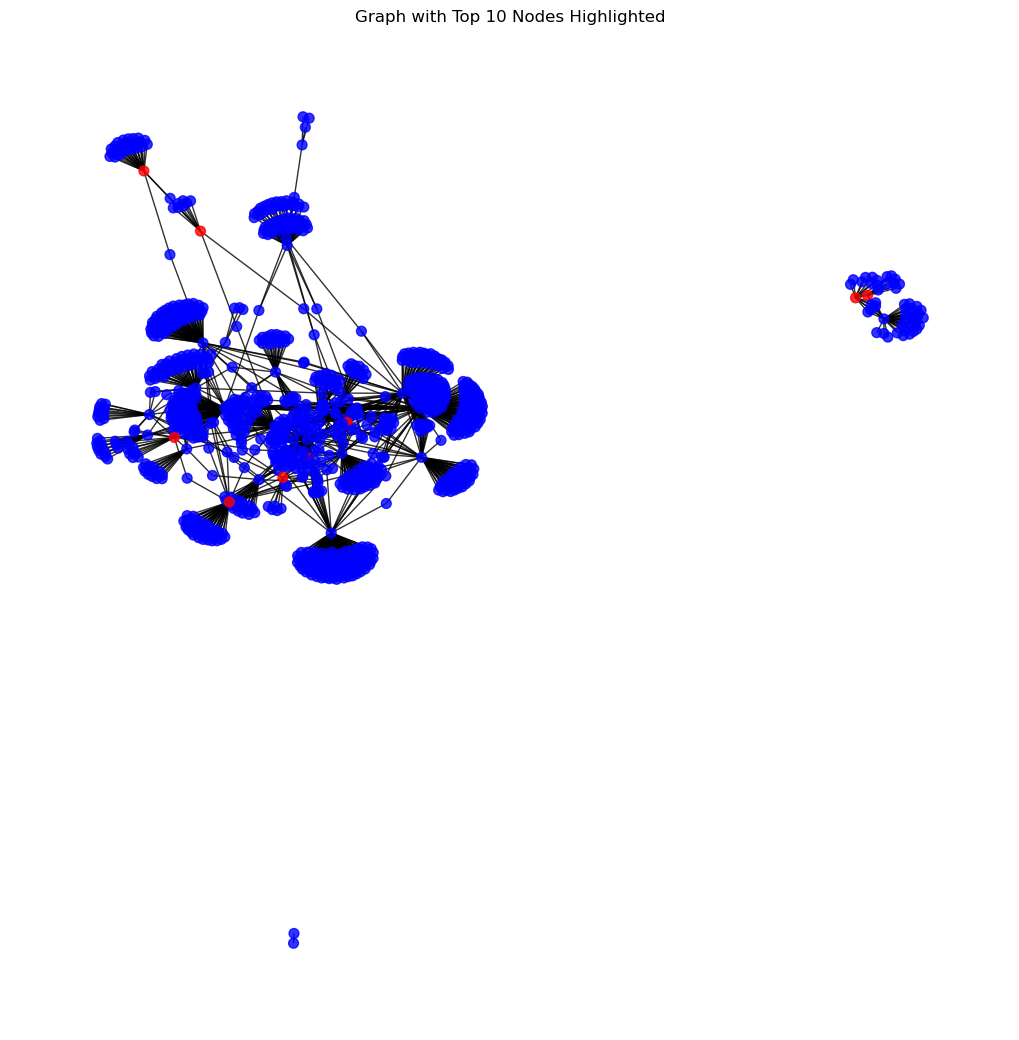

In [31]:
min_score = min(anomaly_scores.values())
max_score = max(anomaly_scores.values())
anomaly_score_normalized = {node: (anomaly_scores[node] - min_score) / (max_score - min_score)
                     for node in nodes}

lof_model = LocalOutlierFactor(n_neighbors=20)
lof_scores = -lof_model.fit_predict(np.array(list(zip(N_values, E_values))))
lof_scores = (lof_scores - np.min(lof_scores)) / (np.max(lof_scores) - np.min(lof_scores))

combined_scores = {node: anomaly_score_normalized[node] + lof_score
                   for node, lof_score in zip(nodes, lof_scores)}

sorted_nodes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

top_10_nodes = [node for node, _ in sorted_nodes[:10]]

color_map = []
for node in G.nodes:
    if node in top_10_nodes:
        color_map.append("red") 
    else:
        color_map.append("blue") 

plt.figure(figsize=(10, 10))
nx.draw(G, node_color=color_map, with_labels=False, node_size=50, alpha=0.8)
plt.title("Graph with Top 10 Nodes Highlighted")
plt.show()

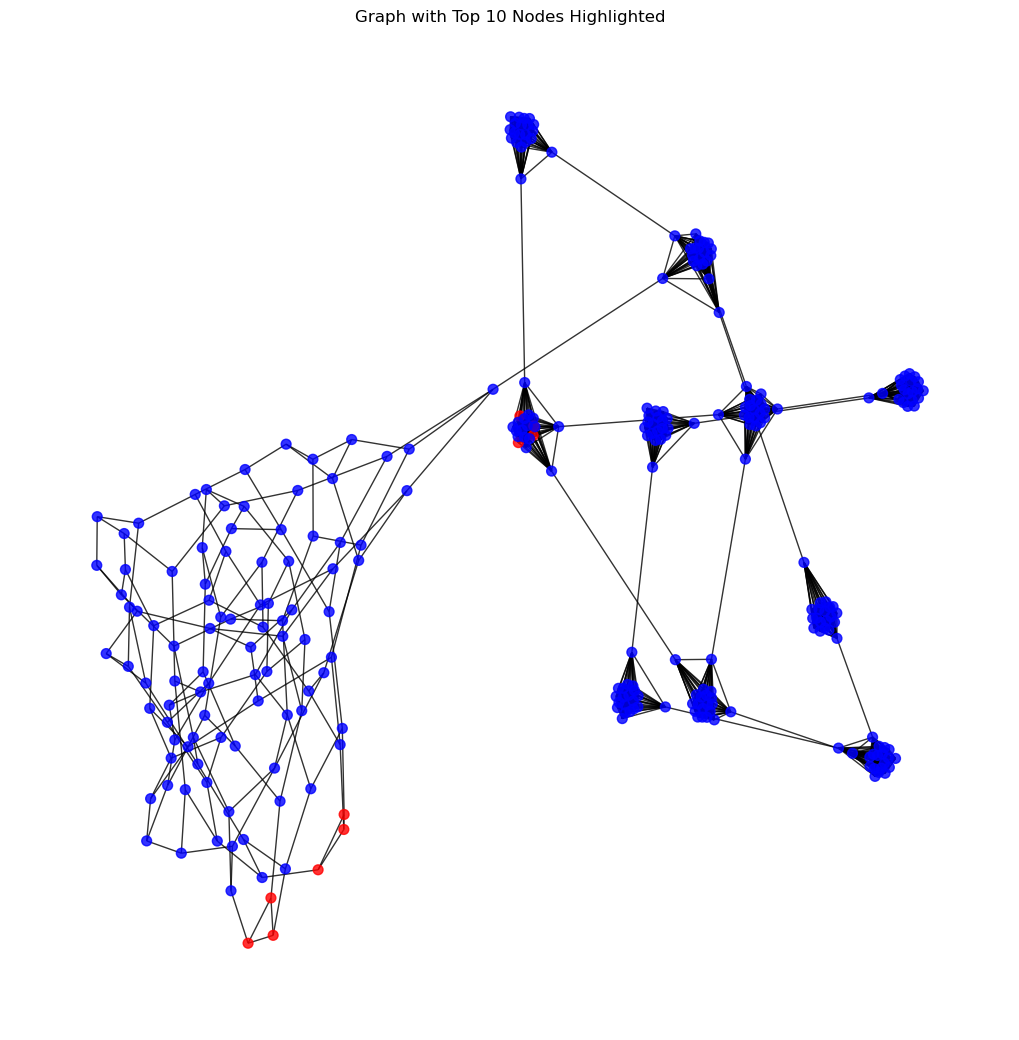

In [42]:
regular_graph = nx.random_regular_graph(d=3, n=100)

caveman_graph = nx.connected_caveman_graph(10, 20)

merged_graph = nx.union(regular_graph, caveman_graph, rename=("r-", "c-"))

all_nodes = list(merged_graph.nodes)
while not nx.is_connected(merged_graph):
    node1, node2 = random.sample(all_nodes, 2)
    if not merged_graph.has_edge(node1, node2):
        merged_graph.add_edge(node1, node2)

nodes = list(merged_graph.nodes)
features = []
for node in nodes:
    neighbors = list(merged_graph.neighbors(node))
    N_i = len(neighbors)
    E_i = len(merged_graph.subgraph(neighbors).edges())
    if N_i > 0 and E_i > 0:
        features.append((node, N_i, E_i))

nodes, N_values, E_values = zip(*features)
log_N = np.log(N_values)
log_E = np.log(E_values)

model = LinearRegression()
log_N = log_N.reshape(-1, 1)
model.fit(log_N, log_E)

theta = model.coef_[0]
log_C = model.intercept_
C = np.exp(log_C)

anomaly_scores = {}
for node, N_i, E_i in features:
    predicted_E = C * (N_i ** theta) 
    score = max(E_i, predicted_E) - min(E_i, predicted_E) * np.log(abs(E_i - predicted_E) + 1)
    anomaly_scores[node] = score

sorted_nodes = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)
top_10_nodes = [node for node, _ in sorted_nodes[:10]]

color_map = []
for node in merged_graph.nodes:
    if node in top_10_nodes:
        color_map.append("red") 
    else:
        color_map.append("blue") 
plt.figure(figsize=(10, 10))
nx.draw(merged_graph, node_color=color_map, with_labels=False, node_size=50, alpha=0.8)
plt.title("Graph with Top 10 Nodes Highlighted")
plt.show()

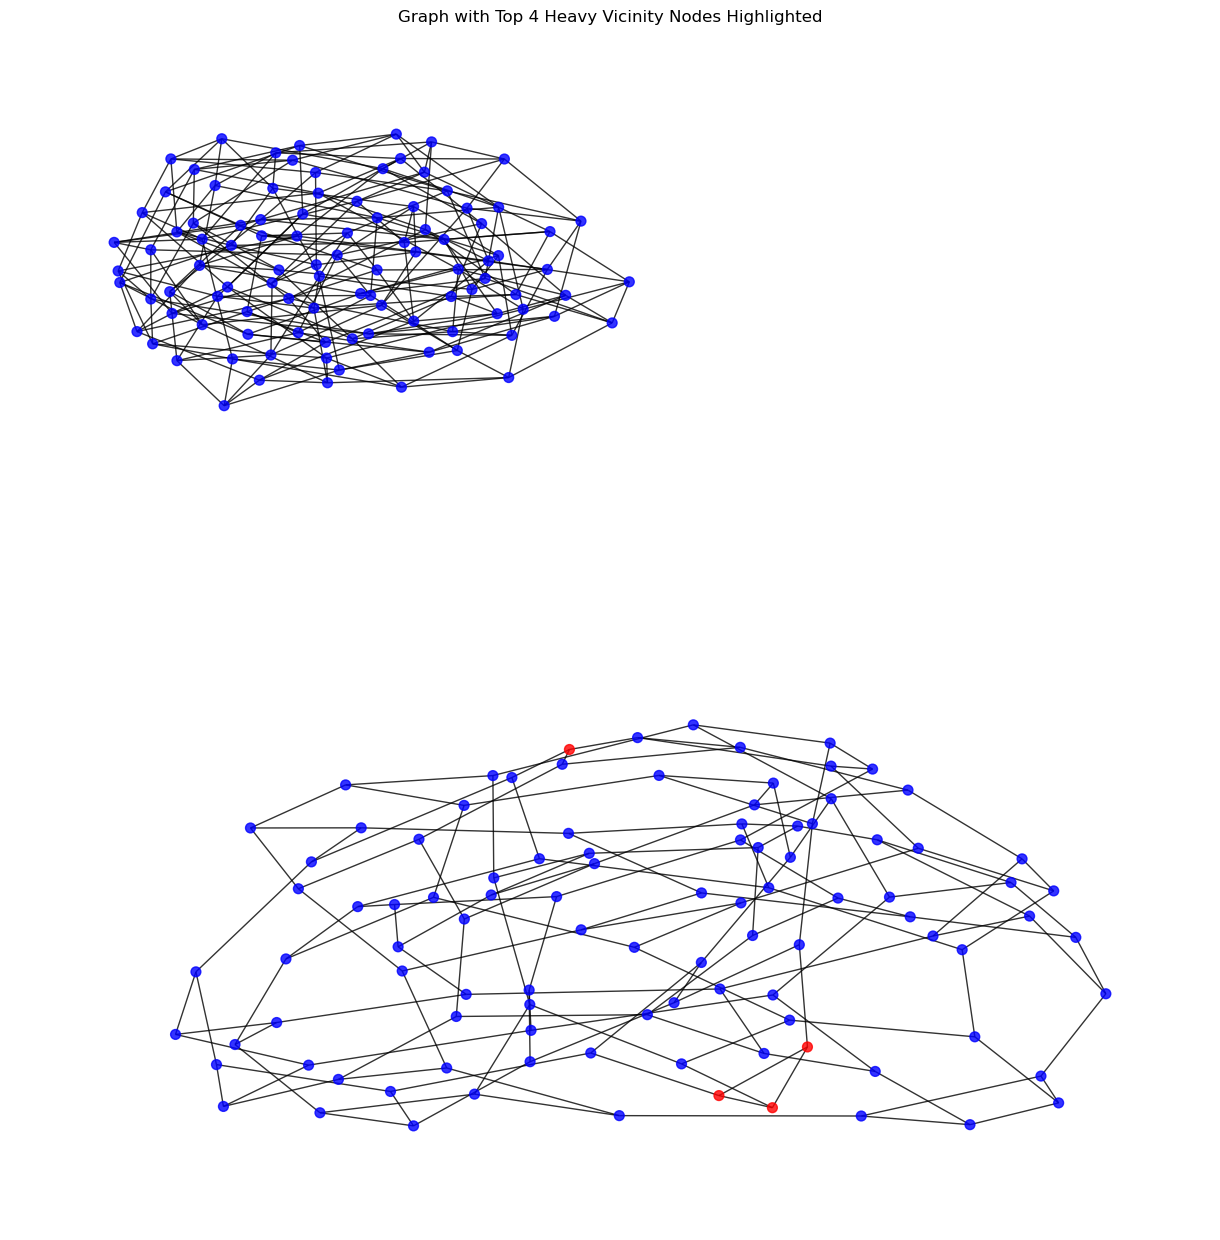

In [9]:
regular_graph_3 = nx.random_regular_graph(d=3, n=100)
regular_graph_5 = nx.random_regular_graph(d=5, n=100) 

merged_graph = nx.union(regular_graph_3, regular_graph_5, rename=("r3-", "r5-"))

for edge in merged_graph.edges:
    merged_graph.add_edge(edge[0], edge[1], weight=1)


nodes = list(merged_graph.nodes)
node1, node2 = random.sample(nodes, 2)

egonet1 = merged_graph.subgraph([node1] + list(merged_graph.neighbors(node1)))
for u, v in egonet1.edges():
    merged_graph[u][v]['weight'] += 10

egonet2 = merged_graph.subgraph([node2] + list(merged_graph.neighbors(node2)))
for u, v in egonet2.edges():
    merged_graph[u][v]['weight'] += 10

scores = {}
features=[]
for node in merged_graph.nodes:
    neighbors = list(merged_graph.neighbors(node))
    egonet = merged_graph.subgraph([node] + neighbors)
    E_i = len(egonet.edges()) 
    W_i = sum(data['weight'] for _, _, data in egonet.edges(data=True)) 
    features.append((node, W_i, E_i))

nodes, W_values, E_values = zip(*features)
log_W = np.log(W_values)
log_E = np.log(E_values)

model = LinearRegression()
log_W = log_W.reshape(-1, 1)
model.fit(log_W, log_E)

theta = model.coef_[0]
log_C = model.intercept_
C = np.exp(log_C)

anomaly_scores = {}
for node, N_i, E_i in features:
    predicted_E = C * (N_i ** theta) 
    score = max(E_i, predicted_E) - min(E_i, predicted_E) * np.log(abs(E_i - predicted_E) + 1)
    anomaly_scores[node] = score

sorted_nodes = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)
top_4_nodes = [node for node, _ in sorted_nodes[:4]]

color_map = []
for node in merged_graph.nodes:
    if node in top_4_nodes:
        color_map.append("red")
    else:
        color_map.append("blue") 
plt.figure(figsize=(12, 12))
nx.draw(merged_graph, node_color=color_map, with_labels=False, node_size=50, alpha=0.8)
plt.title("Graph with Top 4 Heavy Vicinity Nodes Highlighted")
plt.show()




In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x

# Attribute Decoder
class AttributeDecoder(nn.Module):
    def __init__(self, hidden_dim2, hidden_dim1, input_dim):
        super(AttributeDecoder, self).__init__()
        self.conv1 = GCNConv(hidden_dim2, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, input_dim)

    def forward(self, z, edge_index):
        z = self.conv1(z, edge_index)
        z = F.relu(z)
        z = self.conv2(z, edge_index)
        return z

class StructureDecoder(nn.Module):
    def __init__(self):
        super(StructureDecoder, self).__init__()

    def forward(self, z):
        z = F.relu(z)
        adj_reconstructed = torch.matmul(z, z.t())
        return adj_reconstructed


class GAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(GAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2)
        self.attr_decoder = AttributeDecoder(hidden_dim2, hidden_dim1, input_dim)
        self.struct_decoder = StructureDecoder()

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)


        attr_reconstructed = self.attr_decoder(z, edge_index)

        adj_reconstructed = self.struct_decoder(z)

        return z, attr_reconstructed, adj_reconstructed

def custom_loss(x_original, x_reconstructed, a_original, a_reconstructed, alpha=0.8):
    
    attr_loss = torch.norm(x_original - x_reconstructed, p='fro') ** 2
    adj_loss = torch.norm(a_original - a_reconstructed, p='fro') ** 2
    return alpha * attr_loss + (1 - alpha) * adj_loss


In [4]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

acm_data = scipy.io.loadmat('ACM.mat')

attributes = torch.tensor(acm_data['Attributes'].toarray(), dtype=torch.float32)
adj_matrix = acm_data['Network']
labels = torch.tensor(acm_data['Label'].flatten(), dtype=torch.long)

edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)


print(f"Number of nodes: {attributes.size(0)}")
print(f"Number of features: {attributes.size(1)}")
print(f"Number of edges: {edge_index.size(1)}")
print(f"Number of classes: {labels.max().item() + 1}")

print("Sample Node Attributes:", attributes[:5])
print("Sample Edge List:", edge_index[:, :5])
print("Sample Labels:", labels[:5])





Using device: cuda
Number of nodes: 16484
Number of features: 8337
Number of edges: 164350
Number of classes: 2
Sample Node Attributes: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Sample Edge List: tensor([[   0, 2862, 3613, 3924, 5917],
        [   0,    0,    0,    0,    0]])
Sample Labels: tensor([0, 0, 0, 0, 0])


In [ ]:
data = Data(x=attributes, edge_index=edge_index)

input_dim = attributes.shape[1]
hidden_dim1 = 128
hidden_dim2 = 64

model = GAE(input_dim, hidden_dim1, hidden_dim2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)


loader = NeighborLoader(
    data,
    num_neighbors=[15, 10],
    batch_size=64,
    input_nodes=None,
)

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        z, attr_reconstructed, adj_reconstructed = model(batch.x, batch.edge_index)
        batch_adj_matrix = torch.zeros((batch.num_nodes, batch.num_nodes), device=device)
        batch_adj_matrix[batch.edge_index[0], batch.edge_index[1]] = 1
        loss = custom_loss(batch.x, attr_reconstructed, batch_adj_matrix, adj_reconstructed)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            anomaly_scores = []
            for batch in loader:
                batch = batch.to(device)
                z, attr_reconstructed, adj_reconstructed = model(batch.x, batch.edge_index)
                batch_adj_matrix = torch.zeros((batch.num_nodes, batch.num_nodes), device=device)
                batch_adj_matrix[batch.edge_index[0], batch.edge_index[1]] = 1
                attr_errors = torch.sum((attr_reconstructed - batch.x) ** 2, dim=1)
                adj_errors = torch.sum((adj_reconstructed - batch_adj_matrix) ** 2, dim=1)
                batch_anomaly_scores = (attr_errors + adj_errors).cpu().numpy()
                anomaly_scores.extend(batch_anomaly_scores)

            roc_auc = roc_auc_score(labels.cpu().numpy(), np.array(anomaly_scores))
        print(f"Epoch {epoch + 1}/{epochs}, ROC AUC: {roc_auc:.4f}")
